Clasificador de Imágenes 

Rafael Mercado Garduño

A01746991


Contexto:
Detectar plátanos y mangos en buen estado es crucial para garantizar la calidad y seguridad de los productos en la cadena de suministro, desde los productores hasta los consumidores. Al identificar frutas maduras y en óptimas condiciones, se minimizan pérdidas y se optimizan los procesos de almacenamiento y distribución. Además, ayuda a satisfacer la demanda de productos frescos, mejora la experiencia del consumidor y contribuye a reducir el desperdicio de alimentos.

In [30]:
import os
import seaborn as sns
import glob
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, RandomFlip, RandomRotation,
RandomZoom, RandomTranslation)
import warnings
warnings.filterwarnings("ignore")

Este bloque de código importa bibliotecas esenciales para la clasificación de imágenes de plátanos y mangos. Usa `os` y `glob` para gestionar archivos, `cv2` y `PIL` para manipular imágenes, y `matplotlib` para visualizarlas. Además, importa componentes de Keras para construir y entrenar una red neuronal convolucional, así como métricas de sklearn para evaluar el rendimiento del modelo.

In [9]:
train_path = 'C:/Users/rmerc/PycharmProjects/Frutas/Train'
val_path = 'C:/Users/rmerc/PycharmProjects/Frutas/Val'
test_path = 'C:/Users/rmerc/PycharmProjects/Frutas/Test'

Se definen las rutas de los conjuntos de datos de entrenamiento, validación y prueba para la clasificación de plátanos y mangos. El data set se saco de kaggle (https://www.kaggle.com/datasets/muhammad0subhan/fruit-and-vegetable-disease-healthy-vs-rotten) y se separo en proporción 70,20,10 equitativamente cada fruta

In [11]:
def get_images(path, label_map, img_size=(150, 150)):
    X, y = [], []
    for folder in os.listdir(path):
        if folder not in label_map:
            continue 
        folder_path = os.path.join(path, folder)
        images = glob.glob(os.path.join(folder_path, '*.[jp][pn]g'))
        for image in images:
            try:
                image_array = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
                if image_array is None:
                    pil_image = Image.open(image).convert("L")
                    image_array = np.array(pil_image)
                image_array = cv2.resize(image_array, img_size) / 255.0
                image_array = np.expand_dims(image_array, axis=-1)
                X.append(image_array)
                y.append(label_map[folder])
            except Exception as e:
                print(f"Warning: Could not read image {image}. Error: {e}")
    return np.array(X), np.array(y)

label_map = {
    'Banana_Healthy': 0,
    'Banana_Rotten': 1,
    'Mango_Healthy': 2,
    'Mango_Rotten': 3
}

La función `get_images`, carga imágenes de una ruta específica y las etiqueta de acuerdo con un mapa de etiquetas (`label_map`). Itera sobre carpetas de frutas, lee imágenes en escala de grises, las redimensiona a un tamaño definido (`img_size`), y normaliza sus valores. Si hay problemas al leer una imagen, muestra un mensaje de advertencia; finalmente, devuelve las matrices de características (`X`) y etiquetas (`y`) en formato de `numpy`.

In [12]:
X_train, y_train = get_images(train_path, label_map)
X_val, y_val = get_images(val_path, label_map)
X_test, y_test = get_images(test_path, label_map)

En esta parte del código se cargan las imágenes y etiquetas para los conjuntos de datos de entrenamiento, validación y prueba, utilizando la función `get_images` previamente definida. Asigna las imágenes y etiquetas resultantes a las variables `X_train`, `y_train`, `X_val`, `y_val`, `X_test` y `y_test`, respectivamente.

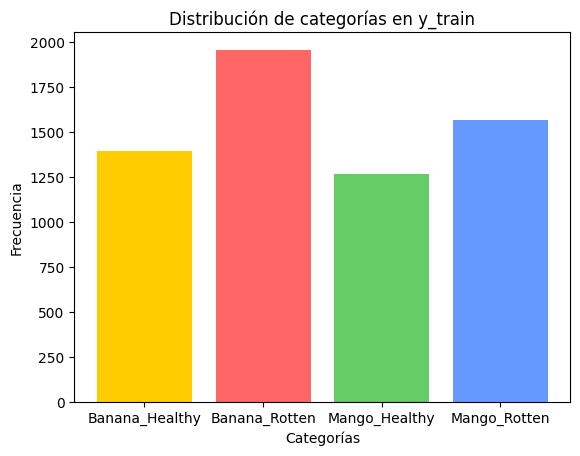

In [13]:
counts = Counter(y_train)
colors = ['#FFCC00', '#FF6666', '#66CC66', '#6699FF'] 
plt.bar(counts.keys(), counts.values(), color=colors, tick_label=list(label_map.keys()))
plt.xlabel("Categorías")
plt.ylabel("Frecuencia")
plt.title("Distribución de categorías en y_train")
plt.show()

Se usa `Counter` para contar la frecuencia de cada categoría en `y_train` y crea un gráfico de barras para visualizar la distribución de las etiquetas y usa `plt.bar` para graficar la cantidad de ejemplos por clase, asignando etiquetas a cada categoría

In [14]:
model_1 = Sequential([
    Input(shape=(150, 150, 1)),
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.2),
    RandomTranslation(0.1, 0.1),
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax') 
])
model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)      │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 150, 150, 1)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_1            │ (None, 150, 150, 1)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,814,852 (26.00 MB)

 Trainable params: 6,813,892 (25.99 MB)

 Non-trainable params: 960 (3.75 KB)

El modelo utiliza una arquitectura basada en capas convolucionales (`Conv2D`) con funciones de activación ReLU, normalización por lotes (`BatchNormalization`) y max-pooling (`MaxPooling2D`) para extraer características y reducir la dimensionalidad espacial de las imágenes. Incluye técnicas de aumento de datos como inversión horizontal (`RandomFlip`), rotación (`RandomRotation`), zoom (`RandomZoom`) y traslación (`RandomTranslation`). Después de procesar las características, las aplanan con una capa `Flatten` y las envían a una capa densa con 512 unidades antes de la capa de salida de 4 neuronas con activación softmax para la clasificación multicategórica. El modelo se compila con el optimizador Adam, la función de pérdida `sparse_categorical_crossentropy` y se evalúa con precisión (`accuracy`).

In [15]:
model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model_1.fit(X_train, y_train, batch_size=16, epochs=15, validation_data=(X_val, y_val))

Epoch 1/15
387/387 ━━━━━━━━━━━━━━━━━━━━ 104s 259ms/step - accuracy: 0.5825 - loss: 4.7330 - val_accuracy: 0.3420 - val_loss: 2.5312
Epoch 2/15
387/387 ━━━━━━━━━━━━━━━━━━━━ 97s 250ms/step - accuracy: 0.6932 - loss: 0.8194 - val_accuracy: 0.7885 - val_loss: 0.5247
Epoch 3/15
387/387 ━━━━━━━━━━━━━━━━━━━━ 139s 242ms/step - accuracy: 0.7520 - loss: 0.6719 - val_accuracy: 0.7525 - val_loss: 0.7051
Epoch 4/15
387/387 ━━━━━━━━━━━━━━━━━━━━ 93s 240ms/step - accuracy: 0.7869 - loss: 0.5865 - val_accuracy: 0.7975 - val_loss: 0.5163
Epoch 5/15
387/387 ━━━━━━━━━━━━━━━━━━━━ 102s 263ms/step - accuracy: 0.7916 - loss: 0.5615 - val_accuracy: 0.6940 - val_loss: 0.7909
Epoch 6/15
387/387 ━━━━━━━━━━━━━━━━━━━━ 91s 236ms/step - accuracy: 0.7976 - loss: 0.5707 - val_accuracy: 0.6513 - val_loss: 1.5801
Epoch 7/15
387/387 ━━━━━━━━━━━━━━━━━━━━ 100s 257ms/step - accuracy: 0.8068 - loss: 0.5383 - val_accuracy: 0.4612 - val_loss: 2.0230
Epoch 8/15
387/387 ━━━━━━━━━━━━━━━━━━━━ 109s 282ms/step - accuracy: 0.8265 - lo

El modelo se entrena durante 15 épocas utilizando el generador de datos (`data_gen`) con el conjunto de entrenamiento, y se evalúa su rendimiento en el conjunto de validación. 

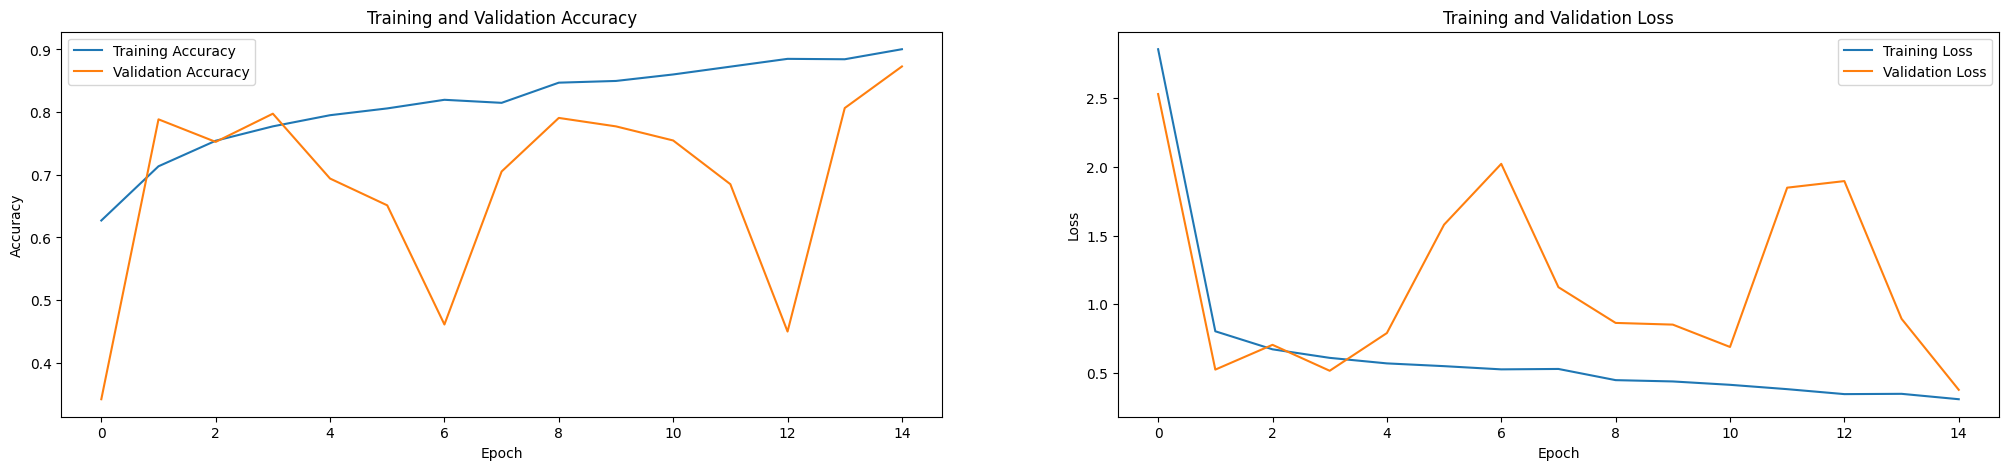

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(25, 5))
axs[0].plot(history.history['accuracy'], label='Training Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend(loc='best')
axs[1].plot(history.history['loss'], label='Training Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend(loc='best')
plt.show()

El gráfico de precisión muestra que la precisión de entrenamiento mejora constantemente, mientras que la precisión de validación fluctúa, alcanzando valores altos pero con variaciones significativas que podrían indicar un problema de generalización o datos inconsistentes. En el gráfico de pérdida, la pérdida de entrenamiento disminuye de manera constante, mientras que la pérdida de validación tiene un comportamiento más inestable, sugiriendo posibles problemas de sobreajuste o desbalance en los datos.

In [17]:
y_pred = model_1.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step


Se generan las predicciones del modelo model_1 sobre el conjunto de prueba X_test. La función predict produce probabilidades para cada clase, y luego np.argmax se utiliza para convertir estas probabilidades en etiquetas de clase (índices de la clase con la mayor probabilidad) para cada imagen de prueba. 

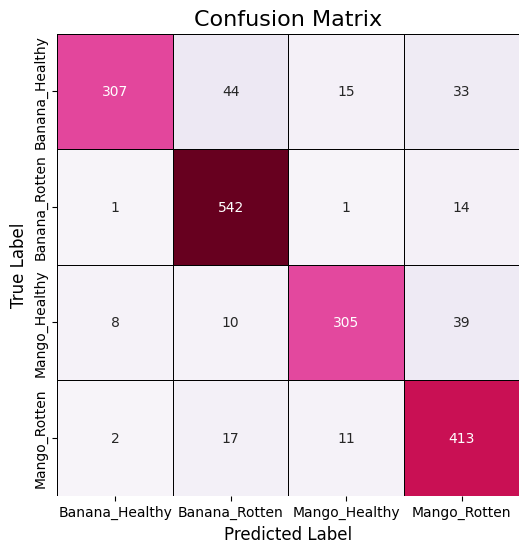

                precision    recall  f1-score   support

Banana_Healthy       0.97      0.77      0.86       399
 Banana_Rotten       0.88      0.97      0.93       558
 Mango_Healthy       0.92      0.84      0.88       362
  Mango_Rotten       0.83      0.93      0.88       443

      accuracy                           0.89      1762
     macro avg       0.90      0.88      0.88      1762
  weighted avg       0.90      0.89      0.89      1762



In [20]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='PuRd', cbar=False, 
            linewidths=0.5, linecolor='black', square=True,
            xticklabels=['Banana_Healthy', 'Banana_Rotten', 'Mango_Healthy', 'Mango_Rotten'],
            yticklabels=['Banana_Healthy', 'Banana_Rotten', 'Mango_Healthy', 'Mango_Rotten'])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()
print(classification_report(y_test, y_pred, target_names=['Banana_Healthy', 'Banana_Rotten', 'Mango_Healthy', 'Mango_Rotten']))

El modelo alcanza una precisión general del 89% con un desempeño balanceado entre las clases, aunque se observa que la clase "Banana_Healthy" tiene un menor recall (77%), lo que indica que no se reconocen todos los casos correctamente. La matriz de confusión muestra un buen nivel de clasificación, aunque existen errores específicos en la predicción de "Banana_Healthy" y "Mango_Healthy", reflejando algunas confusiones entre estas clases con sus contrapartes podridas.

Mejorar el modelo

In [21]:
model_m = Sequential([
    Input(shape=(150, 150, 1)),
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.2),
    RandomTranslation(0.1, 0.1),
    Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(4, activation='softmax') 
])
model_m.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_m.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_2 (RandomFlip)      │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ (None, 150, 150, 1)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_2 (RandomZoom)      │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_2            │ (None, 150, 150, 1)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 148, 148, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,053,892 (72.68 MB)

 Trainable params: 19,053,892 (72.68 MB)

 Non-trainable params: 0 (0.00 B)

La versión mejorada del modelo simplifica la arquitectura al eliminar las capas de normalización por lotes (`BatchNormalization`) y `Dropout`, manteniendo un enfoque más directo en el procesamiento de características. Se incrementó el número de filtros iniciales a 64 en las capas convolucionales para aumentar la capacidad de extracción de características desde el inicio, y se redujo la complejidad al emplear menos bloques convolucionales. Las capas de aumento de datos y la estructura final, que incluye una capa densa de 512 unidades y la salida de 4 neuronas con activación softmax, permanecen iguales, al igual que la configuración de compilación con el optimizador Adam y la función de pérdida `sparse_categorical_crossentropy`.

In [22]:
model_m.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history2 = model_m.fit(X_train, y_train, batch_size=32, epochs=22, validation_data=(X_val, y_val))

Epoch 1/22
194/194 ━━━━━━━━━━━━━━━━━━━━ 52s 260ms/step - accuracy: 0.4768 - loss: 1.2076 - val_accuracy: 0.7615 - val_loss: 0.6502
Epoch 2/22
194/194 ━━━━━━━━━━━━━━━━━━━━ 54s 279ms/step - accuracy: 0.7601 - loss: 0.6014 - val_accuracy: 0.7762 - val_loss: 0.5592
Epoch 3/22
194/194 ━━━━━━━━━━━━━━━━━━━━ 76s 394ms/step - accuracy: 0.8013 - loss: 0.4970 - val_accuracy: 0.8223 - val_loss: 0.4086
Epoch 4/22
194/194 ━━━━━━━━━━━━━━━━━━━━ 77s 396ms/step - accuracy: 0.8524 - loss: 0.3866 - val_accuracy: 0.9066 - val_loss: 0.2673
Epoch 5/22
194/194 ━━━━━━━━━━━━━━━━━━━━ 63s 326ms/step - accuracy: 0.8720 - loss: 0.3491 - val_accuracy: 0.9168 - val_loss: 0.2283
Epoch 6/22
194/194 ━━━━━━━━━━━━━━━━━━━━ 65s 335ms/step - accuracy: 0.8833 - loss: 0.3150 - val_accuracy: 0.9123 - val_loss: 0.2231
Epoch 7/22
194/194 ━━━━━━━━━━━━━━━━━━━━ 65s 335ms/step - accuracy: 0.9033 - loss: 0.2620 - val_accuracy: 0.8830 - val_loss: 0.2974
Epoch 8/22
194/194 ━━━━━━━━━━━━━━━━━━━━ 64s 330ms/step - accuracy: 0.9087 - loss: 0

En comparación con el modelo anterior, model_m muestra una precisión y pérdida significativamente mejores en ambos conjuntos (entrenamiento y validación), alcanzando casi un 96% de precisión en validación, mientras que el modelo anterior rondaba el 89%. Este aumento en el rendimiento puede atribuirse a la mayor cantidad de parámetros en model_m, lo que le permite capturar más características de las imágenes. También se cambio el número de epocas a 22 y el batch a 32

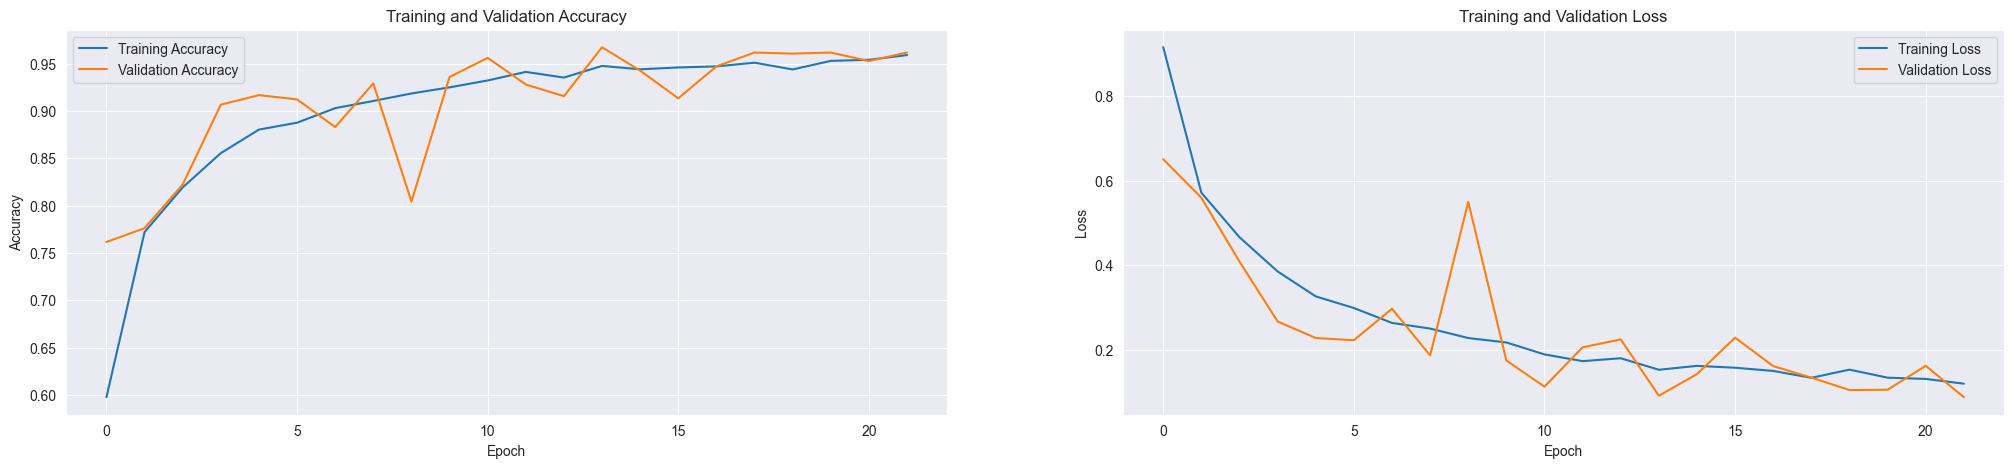

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(25, 5))
axs[0].plot(history2.history['accuracy'], label='Training Accuracy')
axs[0].plot(history2.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend(loc='best')
axs[1].plot(history2.history['loss'], label='Training Loss')
axs[1].plot(history2.history['val_loss'], label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend(loc='best')
plt.show()

En comparación con el modelo anterior, model_m que la precisión de entrenamiento y validación mejoran de manera consistente, alcanzando valores cercanos al 95%, lo que indica un buen ajuste del modelo sin signos de sobreajuste evidente. La pérdida de entrenamiento y validación disminuye de manera uniforme, con ligeras oscilaciones en la pérdida de validación hacia las últimas épocas, pero ambas convergen, reflejando una buena capacidad de generalización.

In [24]:
y_pred2 = model_m.predict(X_test)
y_pred2 = np.argmax(y_pred2, axis=1)

56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step


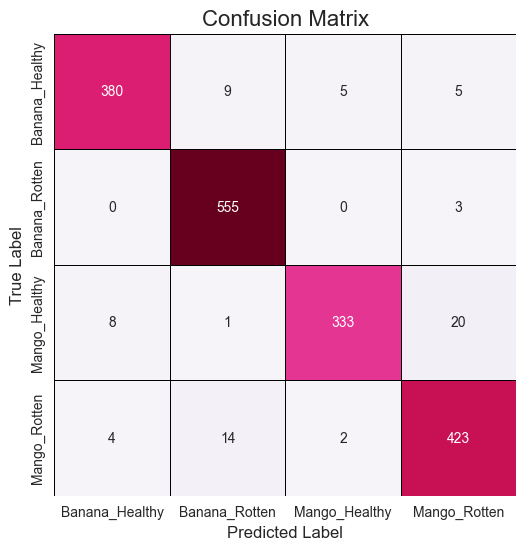

                precision    recall  f1-score   support

Banana_Healthy       0.97      0.95      0.96       399
 Banana_Rotten       0.96      0.99      0.98       558
 Mango_Healthy       0.98      0.92      0.95       362
  Mango_Rotten       0.94      0.95      0.95       443

      accuracy                           0.96      1762
     macro avg       0.96      0.96      0.96      1762
  weighted avg       0.96      0.96      0.96      1762



In [25]:
conf_matrix = confusion_matrix(y_test, y_pred2)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='PuRd', cbar=False, 
            linewidths=0.5, linecolor='black', square=True,
            xticklabels=['Banana_Healthy', 'Banana_Rotten', 'Mango_Healthy', 'Mango_Rotten'],
            yticklabels=['Banana_Healthy', 'Banana_Rotten', 'Mango_Healthy', 'Mango_Rotten'])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()
print(classification_report(y_test, y_pred2, target_names=['Banana_Healthy', 'Banana_Rotten', 'Mango_Healthy', 'Mango_Rotten']))

En comparación con el modelo anterior, model_m muestra una mejora significativa en la precisión, recall y f1-score en todas las categorías, con una precisión general del 96%, con un desempeño equilibrado entre todas las clases, destacando un recall del 99% para "Banana_Rotten", lo que indica una alta capacidad para identificar correctamente esta categoría. La matriz de confusión muestra muy pocos errores, con ligeras confusiones en "Mango_Healthy" y "Mango_Rotten", pero mantiene una excelente generalización global.

In [26]:
model_m.save('model.keras')

Se guardó el modelo model_m como model.keras porque demostró ser el mejor en rendimiento, alcanzando una alta precisión del 97% y mostrando consistencia en la clasificación de todas las categorías. 

In [27]:
def clasificar_imagen(image_path, model):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error: No se pudo cargar la imagen desde {image_path}. Verifica la ruta.")
        return None
    image = cv2.resize(image, (150, 150))
    image = image / 255.0
    image = np.expand_dims(image, axis=(0, -1))
    prediction = model.predict(image)
    class_index = np.argmax(prediction, axis=1)[0]  
    class_labels = ['Banana_Healthy', 'Banana_Rotten', 'Mango_Healthy', 'Mango_Rotten']
    return class_labels[class_index]

Esta función, clasificar_imagen, toma la ruta de una imagen y un modelo como entrada para predecir la clase de la fruta en la imagen. Lee la imagen en escala de grises y la redimensiona a 150x150 píxeles, normalizando los valores de los píxeles. Luego, expande las dimensiones para que coincidan con el formato esperado por el modelo, hace una predicción, y obtiene el índice de la clase con mayor probabilidad. Finalmente, devuelve la etiqueta de la clase correspondiente (Banana_Healthy, Banana_Rotten, Mango_Healthy, o Mango_Rotten).

In [28]:
img_path = r'C:\Users\rmerc\PycharmProjects\Frutas\Platano malo.jpg'
img = clasificar_imagen(img_path, model_m)
img_path2 = r'C:\Users\rmerc\PycharmProjects\Frutas\Mango Bueno.jpg'
img2 = clasificar_imagen(img_path2, model_m)
print("Eso es", img)
print("Eso es", img2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Eso es Banana_Rotten
Eso es Mango_Healthy


En este caso se buscaron en internet imágenes que nunca vio el modelo, la primera imagen corresponde a un plátano no saludable y la segunda a un mango saludable. Según los resultados previos del modelo, model_m clasifica de forma muy precisa los plátanos no saludables (Banana_Rotten), lo cual es una fortaleza del modelo, mientras que la clase de mango saludable (Mango_Healthy) es una de las categorías con más errores en comparación con las demás. Por lo tanto, este ejercicio de clasificación muestra tanto una de las clases mejor clasificadas por el modelo como una de las que presenta más desafíos.

El código desarrollado implementa un modelo de clasificación de imágenes que identifica con alta precisión el estado de plátanos y mangos, diferenciando entre frutas saludables y no saludables. Tras entrenar y evaluar el modelo, se demostró que model_m clasifica especialmente bien los plátanos podridos, mientras que tiene un leve desafío con los mangos saludables